# DATA Transformation - 중고차 가격 예측모델 데이터 [프로젝트]
###**분석자**: 박의진<br>
###**데이터파일**: cars.csv, brand.csv

# 📘 프로젝트 개요: 중고차 가격 예측을 위한 데이터 준비


본 프로젝트의 목표는 `cars.csv`(중고차 개별 정보)와 `brand.csv`(차 브랜드-국가 정보)를 결합하여,  
중고차 가격 예측 또는 클러스터링에 활용 가능한 형태로 **데이터를 정제·변환·축소**하는 것이다.


**1. 필수실습 과제**
- cars.csv와 brand.csv의 데이터 합치기
- 카테고리형 변수를 숫자 형태로 변환하기 (Engine, Emission Class 변수에 주목)
- 결측치 처리하기 (Service history 변수의 결측치는 'Unknown'으로 채우고, 결측치 변수가 일정 개수 이상 포함된 데이터는 제거)
- Scaler 활용
- 기존 데이터 정보의 70% 이상을 가지는 수준에서 최소한의 주성분 추출 (PCA)
---
**2. 선택 실습 과제**

- 국가별 총 브랜드 개수를 살펴 나라별 브랜드 다양성 보기 : groupgy('Country').unique()
- 변수간 상관관계 확인으로 가격에 영향 높은 변수 찾기 : .corr() / sns.heatmap 등

---
이에 따라 본인은 다음 순서로 프로젝트 과제를 수행하였다.

**[데이타 분석 Process]**
- 목표 설정: 중고차 가격 예측 모델을 위한 데이터 분석 및 준비

1) **데이터 확인 :** 구조 및 결측치 현황 파악
2) **데이터 결합 :** `title`에서 브랜드 이름 추출 후 `brand.csv`와 병합하여 브랜드/국가 정보 추가
3) **결측치 처리 :** (Service history, Previous Owners, Engine, Doors, Seats 등)  
4) **카테고리형 처리 :** `Engine`, `Emission Class`에 대한 원-핫 인코딩(One-Hot Encoding)
5) **스케일링으로 데이터 단위 표준화/정규화 :** `Price`, `Mileage(miles)`, `Registration_Year`, `Previous Owners`에 대해 RobustScaler로 스케일링
6) **PCA 로 차원 축소 :** PCA를 이용해 4개 수치형 변수 → 2개 주성분으로 차원 축소  
7) **(선택 실습)** 상관관계 분석 및 나라별 브랜드 다양성(브랜드 개수) 확인

In [5]:
#데이터 분석 기본 세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#데이터 불러오기
cars = pd.read_csv('cars.csv')

In [7]:
brand = pd.read_csv('brand.csv')

In [8]:
#데이터 쓱 둘러보기
cars.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [9]:
cars.info()
cars.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 374.6+ KB


(3687, 13)

In [10]:
brand.head()

,title,country
0,skoda,Czech Republic
1,vauxhall,United Kingdom
2,hyundai,South Korea
3,mini,United Kingdom
4,ford,United States


In [11]:
brand.info()
brand.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    48 non-null     object
 1   country  48 non-null     object
dtypes: object(2)
memory usage: 900.0+ bytes


(48, 2)

## Step 1. 브랜드 정보 결합 (cars + brand)

[관찰 결과]
cars 파일의 title은 모델명까지 붙어있어서 길고, 브랜드 파일의 title은 브랜드명만 있는 형태임. 그리고 대소문자도 서로 다름.

[결측 처리 방향]
긴쪽의 앞단어만 선택하여 Title 컬럼을 통일성있게 병합하여 Brand라는 독립변수로 정리하고, 소문자+공백처리로 값을 정규화하기로 함.

In [12]:
#띄어쓰기 기준 분리 후 앞만 선택
cars['Brand'] = cars['title'].str.split().str[0]

#brand 파일의 컬럼명 정리
brand = brand.rename(columns = {'title' : 'Brand', 'country' : 'Brand_Country' })

#소문자 통일 및 공백 제거 (병합키)
cars['Brand_new'] = cars['Brand'].str.strip().str.lower()
brand['Brand_new'] = brand['Brand'].str.strip().str.lower()

#정리한 Brand_new 기준으로 두 파일 병합해주기 (데이터프레임에서 여러열 선택시 대괄호 두번)
cars_new = pd.merge(cars, brand[['Brand_new', 'Brand_Country']], on = 'Brand_new', how = 'left')

In [13]:
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_new,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,SKODA,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,VAUXHALL,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,HYUNDAI,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,MINI,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,VAUXHALL,vauxhall,United Kingdom


In [14]:
#중복되는 Brand 컬럼은 삭제 (에러 자꾸 나서 errors = 'ignore')르 사용하니 해결됨
cars_new = cars_new.drop(columns = ['Brand'], errors='ignore')

In [15]:
#깔끔하게 다시 브랜드랑 브랜드 국가 이름 재정리
cars_new = cars_new.rename(columns={'Brand_new' : 'Brand'})
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN,vauxhall,United Kingdom


## Step 2. 결측치 처리 전략

`cars_new.info()` 기준으로 결측이 특히 많이 발생한 컬럼은 다음과 같다.

- `Service history` : 결측 매우 많음  
- `Previous Owners` : 결측 다수  
- `Engine`, `Doors`, `Seats`, `Emission Class` : 일부 결측

[결측 처리 방향]

1. **Service history**  
   - 기록 여부가 중요한 범주형 변수로, 결측은 “이력이 불명확한 경우”로 해석.  
   - 따라서 결측을 `'Unknown'` 으로 대체하여 **정보 손실을 최소화**하기로 함.

2. **Previous Owners**  
   - 숫자형이지만 0명의 실제 의미 구분(신차인지, 정보없음 인지) 이 어려움.
   - 따라서 결측을 `-1`로 채워 “**정보 없음**”인지 알 수 있게 하고  
     이후 모델링 단계에서 별도 범주로 관리할 수 있게 함.

3. **Engine, Emission Class**  
   - 범주형(문자열) 변수로, 결측을 `'Unknown'` 으로 처리 후  
     나중에 원-핫 인코딩 시 카테고리 유형으로 다룰 수 있게 함.

4. **Doors, Seats**  
   - 수치형이면서 값의 범위(2~7)가 제한적인 변수이므로  
     중앙값(median)으로 대체하여 **분포 왜곡을 최소화**하려고 함.

또한, 전체적으로 결측이 너무 많은 행은  
`dropna(thresh=10)`을 사용하여 **최소 10개 이상의 정보가 있는 행만 남기도록 필터링**함.

In [16]:
cars_new.info()
cars_new.shape

#결측치 파악 :  Service history (매우높음), Previous Owners (상당함), Doors / Seats / Engine / Emission Class(일부 결측)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    2276 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3642 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3662 non-null   float64
 10  Seats              3652 non-null   float64
 11  Emission Class     3600 non-null   object 
 12  Service history    540 non-null    object 
 13  Brand              3687 non-null   object 
 14  Brand_Country      3687 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 432.2+ KB


(3687, 15)

In [17]:
#Service history 결측처리
cars_new['Service history'] = cars_new['Service history'].fillna('Unknown')


In [18]:
#한 컬럼 내 고유값 빈도수 확인  그리고 이게 이미 정수형 처리 되어있음 확인
cars_new['Service history'].value_counts()

Service history
Unknown    3147
Full        540
Name: count, dtype: int64

In [19]:
#정보량이 일정 수준 이상 빠진 샘플(행)은 제거/ thresh=N 결측이 아닌 값이 최소 N개 이상은 있어야 남긴다. (결측이 있는 컬럼이 5개 정도로 파악되므로)
cars_new = cars_new.dropna(thresh = 10)
cars_new.isna().sum()

title                   0
Price                   0
Mileage(miles)          0
Registration_Year       0
Previous Owners      1411
Fuel type               0
Body type               0
Engine                 45
Gearbox                 0
Doors                  25
Seats                  35
Emission Class         87
Service history         0
Brand                   0
Brand_Country           0
dtype: int64

In [20]:
#Previous Owners 는 결측이 많으나 정보 부재가 현재 소유주 1명만 거쳤다는 의미인지 정보없음인지 모르니 그냥 정보없음 처리로 (자료형이 float이므로 -1처리로)
cars_new['Previous Owners'] = cars_new['Previous Owners'].fillna(-1)

In [21]:
# 남은 결측 컬럼 특성 확인
# Engine(단위문자가 포함된 수치 - 카테고리형) : 범주형 결측은 1차로 Unknown 처리 -> 나중에 원핫인코딩할거임
# Emission Class(문자로 된 수치 등급 - 카테고리형)

cars_new['Engine'] = cars_new['Engine'].fillna('Unknown')
cars_new['Emission Class'] = cars_new['Emission Class'].fillna('Unknown')

# Doors(1-5개 예상: 수치형 -> 중앙값 대체)
# Seats(2-9인승 예상 :수치형 -> 중앙값 대체)


In [22]:
cars_new[['Engine', 'Emission Class']].isna().sum() #위 처리 결과 확인


Engine            0
Emission Class    0
dtype: int64

In [23]:
#수치형 결측 컬럼 처리 -> 중앙값으로 대체하여 채우기

cars_new[['Doors', 'Seats']].isna().sum()

Doors    25
Seats    35
dtype: int64

In [24]:
cars_new['Doors'] = cars_new['Doors'].fillna(cars_new['Doors'].median())

In [25]:
cars_new['Seats'] = cars_new['Seats'].fillna(cars_new['Seats'].median())

In [26]:
cars_new[['Doors', 'Seats']].isna().sum()

Doors    0
Seats    0
dtype: int64

In [27]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              3687 non-null   object 
 1   Price              3687 non-null   int64  
 2   Mileage(miles)     3687 non-null   int64  
 3   Registration_Year  3687 non-null   int64  
 4   Previous Owners    3687 non-null   float64
 5   Fuel type          3687 non-null   object 
 6   Body type          3687 non-null   object 
 7   Engine             3687 non-null   object 
 8   Gearbox            3687 non-null   object 
 9   Doors              3687 non-null   float64
 10  Seats              3687 non-null   float64
 11  Emission Class     3687 non-null   object 
 12  Service history    3687 non-null   object 
 13  Brand              3687 non-null   object 
 14  Brand_Country      3687 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 432.2+ KB


## Step 3. 카테고리형 변수 → 숫자형 (One-Hot Encoding)

과제에서 명시적으로 요구한 카테고리형 → 숫자형 변환 대상은 다음 두 변수임.

- `Engine` : 배기량(예: 1.2L, 1.4L 등) -> 서열형 문자열
- `Emission Class` : 배출가스 등급(예: Euro 4, Euro 5 등) ->범주  
  
[전처리 방향]  

이 두 변수는 **서열/범주 정보**를 담고 있으므로,  
각 고유값에 대해 더미 변수(0/1)를 만드는 **원-핫 인코딩**을 적용하여 모델에 넣을 수 있는 형태로 변환

In [28]:
#과제에서 요구하는 결측치 컬럼 중 오브젝트형 (Engine, Emission Class) 먼저 숫자형으로 변환

#인코딩 할 컬럼명 리스트로 일단 묶어두기
cat_vars = ['Engine', 'Emission Class']

#인코딩
cars_encoded = pd.get_dummies(cars_new, columns = cat_vars, drop_first = True, dtype = int)


In [29]:
cars_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3687 non-null   object 
 1   Price                   3687 non-null   int64  
 2   Mileage(miles)          3687 non-null   int64  
 3   Registration_Year       3687 non-null   int64  
 4   Previous Owners         3687 non-null   float64
 5   Fuel type               3687 non-null   object 
 6   Body type               3687 non-null   object 
 7   Gearbox                 3687 non-null   object 
 8   Doors                   3687 non-null   float64
 9   Seats                   3687 non-null   float64
 10  Service history         3687 non-null   object 
 11  Brand                   3687 non-null   object 
 12  Brand_Country           3687 non-null   object 
 13  Engine_0.9L             3687 non-null   int64  
 14  Engine_1.0L             3687 non-null   

##  Step 4. 스케일링 (RobustScaler)

`Price`, `Mileage(miles)`, `Registration_Year`, `Previous Owners`는  
서로 단위와 값의 범위가 크게 다른 수치형 변수들이므로 같은 기준 축 위에 올려주는 스케일링 필요함.

- `Price` : 400 ~ 33,900까지 넓게 분포 -> 편차 너무 큼  
- `Mileage(miles)` : 1 ~ 1,110,100 (주행거리) -> 단위 너무 크고 편차 역시 큼
- `Registration_Year` : 연도 기반(1953 ~ 2025)  -> 범주 평균이 특정 4자리에 몰려있음
- `Previous Owners` : -1(정보 없음) ~ 9 ->상대적으로 값 작고 범주도 좁음

[스케일링 방향]<br>
범주가 많이 차이나서 이상치에 덜 민감한 `RobustScaler`를 사용해 스케일링하기로 함.

- 중앙값을 0, IQR(사분위 범위)을 1 기준으로 맞추어  
  **극단값의 영향을 완화**하고 PCA 및 모델링에 적합한 형태로 변환


In [30]:
#열이 많아졌으니 스케일링과 PCA로 통계적으로 다듬고 차원 축소시켜보는 단계로 넘어감.

cars_encoded.describe()

,Price,Mileage(miles),Registration_Year,Previous Owners,Doors,Seats,Engine_0.9L,Engine_1.0L,Engine_1.1L,Engine_1.2L,...,Engine_5.0L,Engine_5.5L,Engine_6.3L,Engine_Unknown,Emission Class_Euro 2,Emission Class_Euro 3,Emission Class_Euro 4,Emission Class_Euro 5,Emission Class_Euro 6,Emission Class_Unknown
count,3687.000000,3.687000e+03,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,...,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000
mean,5787.301058,8.132854e+04,2011.846216,1.350420,4.326010,4.901275,0.004068,0.088419,0.010578,0.141307,...,0.000814,0.000271,0.000271,0.012205,0.006781,0.037158,0.289666,0.340928,0.300787,0.023596
std,4480.629885,3.941718e+04,5.082387,2.213831,0.984984,0.574382,0.063662,0.283941,0.102316,0.348386,...,0.028517,0.016469,0.016469,0.109815,0.082076,0.189173,0.453669,0.474085,0.458662,0.151809
min,400.000000,1.000000e+00,1953.000000,-1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2490.000000,5.698400e+04,2008.000000,-1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4000.000000,8.000000e+04,2012.000000,1.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7995.000000,1.030000e+05,2015.500000,3.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000,5.000000,7.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

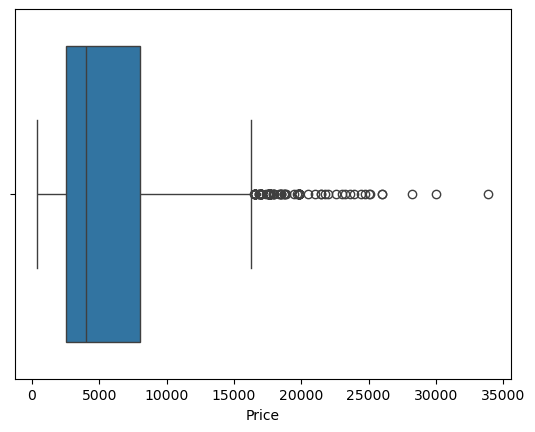

In [31]:
#스케일링 가기 전 이상치 부분 확인을 위해 시각화로 후보 컬럼 몇개만 확인
import matplotlib.pyplot as plt
import seaborn as sns

#Price 분포 보기
sns.boxplot(x=cars_encoded['Price'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

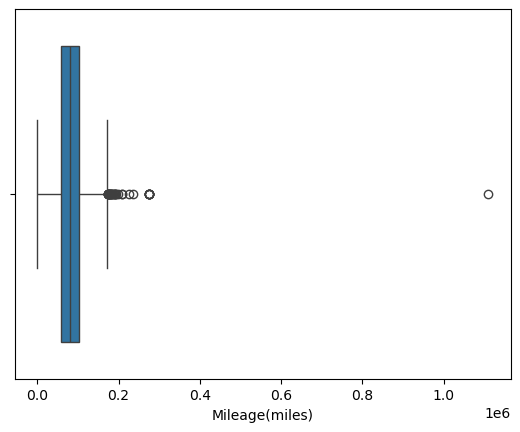

In [32]:
#Mileage(주행거리) 분포 보기
sns.boxplot(x=cars_encoded['Mileage(miles)'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

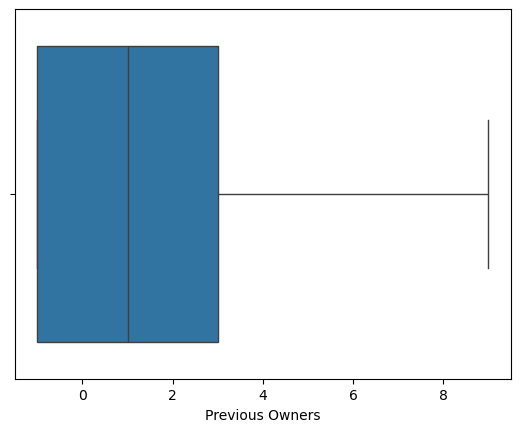

In [33]:
#Previous Owners(이전 소유자수)분포 보기
sns.boxplot(x=cars_encoded['Previous Owners'])
plt.show

In [34]:
#환경 세팅한 뒤, 스케일링 대상 변수 선택 - 인코딩 컬럼은 제외하고 door나 seats처럼 범주 적고 해석단위 작은 경우 제외

#이상치 몇 개 튀는 것들이 위의 시각화에서 관찰되었으므로 RobustScaler는 중앙값 기준 이상치 영향 최소화이므로 이걸 선택

from sklearn.preprocessing import RobustScaler

scale_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners']

scaler = RobustScaler() #스케일러라는 객체 만들기
cars_scaled = pd.DataFrame(scaler.fit_transform(cars_encoded[scale_cols]))


In [35]:
#스케일러 적용 결과 전 후 확인
cars_encoded[scale_cols].describe()

,Price,Mileage(miles),Registration_Year,Previous Owners
count,3687.000000,3.687000e+03,3687.000000,3687.000000
mean,5787.301058,8.132854e+04,2011.846216,1.350420
std,4480.629885,3.941718e+04,5.082387,2.213831
min,400.000000,1.000000e+00,1953.000000,-1.000000
25%,2490.000000,5.698400e+04,2008.000000,-1.000000
50%,4000.000000,8.000000e+04,2012.000000,1.000000
75%,7995.000000,1.030000e+05,2015.500000,3.000000
max,33900.000000,1.110100e+06,2025.000000,9.000000


In [36]:
cars_scaled.describe()  #데이터 중앙값이 잘 0으로 바뀌어서 적용 완료됨

,0,1,2,3
count,3687.000000,3687.000000,3687.000000,3687.000000
mean,0.324669,0.028871,-0.020504,0.087605
std,0.813920,0.856597,0.677652,0.553458
min,-0.653951,-1.738504,-7.866667,-0.500000
25%,-0.274296,-0.500174,-0.533333,-0.500000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.725704,0.499826,0.466667,0.500000
max,5.431426,22.385692,1.733333,2.000000


## Step 5. PCA를 이용한 차원 축소

스케일링한 4개 변수(`Price`, `Mileage(miles)`, `Registration_Year`, `Previous Owners`)를 대상으로 주성분 분석(PCA)을 수행<br>  
즉, 비슷한 정보가 중복된 변수는 합쳐 데이터를 단순, 효율, 분석하기 쉽게 만들고 분산을 가장 잘 설명하는 방향으로 표현하여 모델링에 용이한 상태로 만드는 것이 필요함.

- 설명 분산 비율:
  - PC1 : 약 60.5%  
  - PC2 : 약 19.3%  
  - → 두 축을 합하면 전체 정보의 약 **80%** 를 유지 가능

In [37]:
#주성분 분석으로 차원축소 진행
from sklearn.decomposition import PCA

pca = PCA() #PCA 객체 생성

pca_transformed = pca.fit_transform(cars_scaled) #PCA 학습 및 변환 적용


In [38]:
#주성분별 분산 비율 확인 - PCA1,2의 합이 0.798이니까 약 80% 정보유지하므로 n_components= 2로 설정
explained = pca.explained_variance_ratio_
explained

array([0.60526092, 0.19339361, 0.13312043, 0.06822504])

In [39]:
#찾은 최소축 수 PCA 반영

pca_final = PCA(n_components = 2)
cars_pca = pca_final.fit_transform(cars_scaled)



In [40]:
#결과 확인  - 컬럼이 2개로 차원 축소 되었는지 확인
cars_pca.shape

(3687, 2)

In [51]:
pca_final.components_

array([[ 0.63186157, -0.60015792,  0.47331254, -0.12859495],
       [ 0.43595799,  0.77861076,  0.43648241,  0.11484346]])

In [52]:
#PCA 주성분에 해당되는 변수별 영향(기여도) 확인 - 위의 결과를 2열 4행으로 전치 시켜서 보기 / round(3) 소수점 3자리까지 반올림
feature_ratio = pd.DataFrame(pca_final.components_.T, index = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners'], columns = ['PC1', 'PC2']).round
feature_ratio

<bound method DataFrame.round of                         PC1       PC2
Price              0.631862  0.435958
Mileage(miles)    -0.600158  0.778611
Registration_Year  0.473313  0.436482
Previous Owners   -0.128595  0.114843>

주성분 기여도 해석결과
  - **PC1** : `Price(+)`, `Registration_Year(+)`, `Mileage(miles)(-)`  
    → 차량 가치 축 (고가, 연식, 저주행)으로 해석 가능
  - **PC2** : 주행량 중심의 보조 축으로 해석 가능

- `Previous Owners`는 두 축 모두에서 기여도가 작아,  
  **주요 설명 변수로 보긴 어려움.

이를 통해, 중고차의 핵심 특성은  
**“연식 + 주행거리 + 가격” 3가지 축이 대부분을 설명**한다는 점을 정량적으로 확인할 수 있었음.<br>
(참고) PCA 축 해석하는 법 : 기여도의 크기(=중요도)는 절대값으로 보고, 부호(+, −) 는 관계의 방향을 의미

In [53]:
#위의 결과로 가격에 영향을 주는 것은 연식과 주행거리가 가장 연관성이 있어보임. 이거를 corr를 이용한 변수간 상관관계 확인 후 시각화 해보기
corr_df = cars_encoded[['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners']].corr()
corr_df

,Price,Mileage(miles),Registration_Year,Previous Owners
Price,1.000000,-0.500358,0.722971,-0.173554
Mileage(miles),-0.500358,1.000000,-0.410781,0.190335
Registration_Year,0.722971,-0.410781,1.000000,-0.142582
Previous Owners,-0.173554,0.190335,-0.142582,1.000000


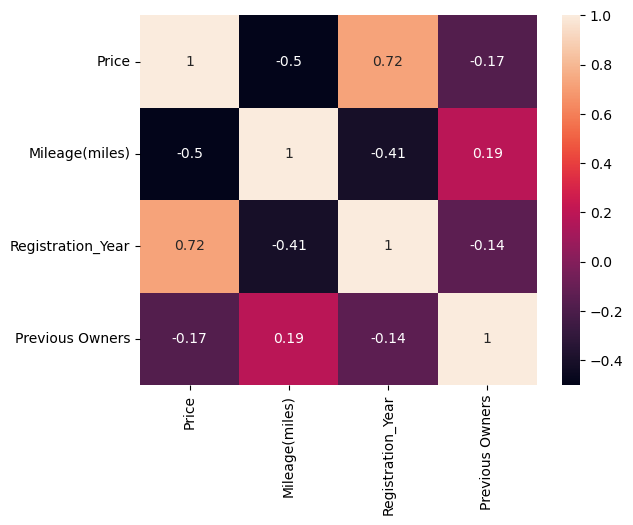

In [54]:
sns.heatmap(corr_df, annot = True)
plt.show()

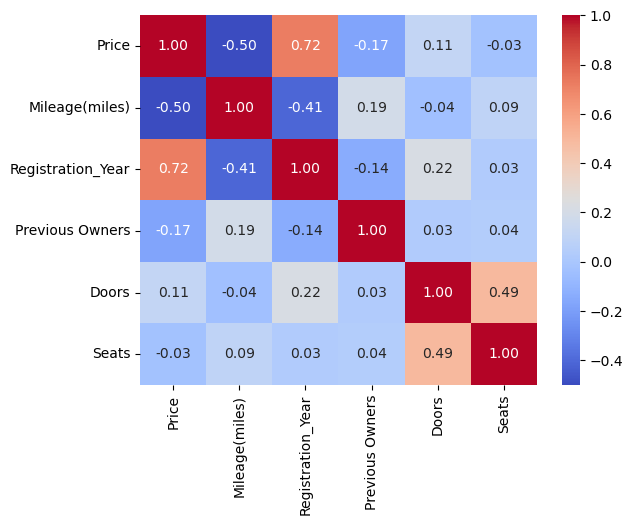

In [55]:
#전체 데이터 안의 수치변수 간의 상관관계 시각화해보기

numeric_cols = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Doors', 'Seats']

corr_numeric = cars_encoded[numeric_cols].corr()
sns.heatmap(corr_numeric, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.show()

## Step 6. 상관관계 분석 결과

1. **수치형 변수 간 상관관계**

- `Price`와 `Registration_Year` : **0.72 (강한 양의 상관관계)**  
  → 최근 연식일수록 가격이 높다.
- `Price`와 `Mileage(miles)` : **-0.50 (중간 정도의 음의 상관관계)**  
  → 많이 달린 차량일수록 가격이 낮다.
- `Mileage(miles)`와 `Registration_Year` : **-0.41 (음의 상관관계)**  
  → 오래된 차량일수록 주행거리가 많다.

즉, 가격은 **연식(신형/구형)** 과 **주행거리(저주행/고주행)** 두 요소에 의해 가장 크게 설명되며,  
`Previous Owners`, `Doors`, `Seats` 등은 상대적으로 영향력이 낮은 변수로 파악됨.

In [56]:
#[추가실습] 나라별 차 브랜드 개수를 살펴 다양성 확인해보기

In [57]:
cars_new.head()

,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history,Brand,Brand_Country
0,SKODA FABIA,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,Unknown,skoda,Czech Republic
1,VAUXHALL CORSA,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full,vauxhall,United Kingdom
2,HYUNDAI I30,949,137000,2011,-1.0,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,Unknown,hyundai,South Korea
3,MINI HATCH,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full,mini,United Kingdom
4,VAUXHALL CORSA,1000,85000,2013,-1.0,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,Unknown,vauxhall,United Kingdom


In [49]:
cars_new.groupby('Brand_Country')['Brand'].unique() #고유값들 먼저 뭐 있는지 나라별 구분

Brand_Country
Czech Republic                                              [skoda]
France                              [peugeot, citroen, renault, ds]
Germany           [bmw, mercedes-benz, volkswagen, audi, porsche...
Italy                                [alfa, fiat, abarth, maserati]
Japan             [mazda, honda, toyota, nissan, mitsubishi, lex...
Malaysia                                                   [proton]
Romania                                                     [dacia]
South Korea                       [hyundai, kia, daewoo, ssangyong]
Spain                                                        [seat]
Sweden                                                [volvo, saab]
United Kingdom    [vauxhall, mini, mg, land, jaguar, rover, marc...
United States              [ford, chevrolet, jeep, chrysler, dodge]
Name: Brand, dtype: object

In [50]:
cars_new.groupby('Brand_Country')['Brand'].nunique()

Brand_Country
Czech Republic     1
France             4
Germany            6
Italy              4
Japan             11
Malaysia           1
Romania            1
South Korea        4
Spain              1
Sweden             2
United Kingdom     8
United States      5
Name: Brand, dtype: int64

## Step 7. 추가 분석 (선택 실습) -나라별 브랜드 다양성

`Brand_Country`별 고유 `Brand` 개수를 집계한 결과,

- 일본 : 11개 브랜드로 **가장 다양한 브랜드 구성**  
- 영국, 독일, 미국 등도 비교적 다양한 브랜드를 보유  
- 말레이시아, 루마니아, 체코 등은 1~2개 브랜드 중심

이를 통해 데이터셋이 **일본과 유럽 중심의 브랜드 구성을 가진 중고차 시장**을 반영한 자료임을 알 수 있었음.
</span>

## 프로젝트 회고 (Reflection)

### 1️⃣ 배운 점 & 성장

<span style="color:#d62728">
- 데이터셋 하나가 아닌 연관된 복수의 데이터셋을 다루는 방법에 대해서 배우고 경험했음. <br>
- 병합하는 방법도 여러가지가 있어서 나중에 분석 및 모델링을 위해 어떤 기준과 형태로 병합하는 것이 효과적일지 판단하는 것이 필요하다는 것을 깨달았음.<br>   
- 결측치 처리에서도 단순히 `dropna()`로 지우는 대신, --> `-1`처럼  
  **변수의 의미를 고려해 값에 의미를 실어 채우는 방식**을 연습할 수 있었음.<br>
- `Engine`, `Emission Class`에 대한 원-핫 인코딩,  
  수치형 변수에 대한 RobustScaler 적용, PCA로의 차원 축소까지  
  **전처리 → 스케일링 → 차원 축소**라는 전형적인 머신러닝 준비 과정을  
  처음부터 끝까지 한 번 “직접 손으로” 따라가며 감을 잡는 기회였다고 생각함.<br>
- 상관관계를 분석하는 스텝도 단순히 수치로만 확인했던 내용을 시각화로 점검한다는 개념을 넘어서 **“모델에서 쓸 핵심 변수 후보를 고르는 탐색 과정”**이라고 재해석할 수 있었음. </span>

---

### 2️⃣ 느낀 한계 & 보완 방향

<span style="color:#d62728">
- 결측치 기준(`thresh=10`)이나 `Previous Owners = -1` 처리 등은  
  직관과 수업 내용을 바탕으로 한 **경험적 판단**에 가까웠다고 생각함.  
  향후에는 다른 기준(IQR, 도메인 지식 등)과 함께 비교해서 좀 더 논리적인 접근이 필요하다고 보여짐. <br>
- PCA 결과를 해석하는 것이 쉽지 않았음  “PC1 = 차량 가치 축, PC2 = 주행량 기반 보조 축”이라는 해석은 했지만, 직관적으로 확인 할 수 있도록 시각화 등을 더해 추가 분석 등이 가능했을텐데 그렇게까지는 진행하지 못해 아쉬움.
- 이번 프로젝트는 실습내용 확인을 주목적으로 전처리·PCA·상관관계 위주로 연습하는데 내용이 머물렀고, 실제 현업에서 궁금해할만한 새로운 인사이트 등을 끌어내지 못한 것이 아쉬움.   

</span>

---

### 3️⃣ 앞으로의 계획

<span style="color:#d62728">
- 이번에 정제한 데이터를 활용해 실제 머신러닝까지 시행해본다면 결과를 비교해보면서 앞 단계에서 좀 더 고민했었어야 할 변환 및 정제 스텝들이 추가로 발견되지 않을까 예상함. <br>
- 시간상 프로젝트에서는 표준 프로세스를 따라가는 방식으로 진행했지만, 실제 업무를 할 때는 한번의 흐름으로만 데이터 분석이 끝나지 않을 것이라는 것을 깨달음.<br>
- 과제를 수행하는 시간적 여유가 좀 더 주어진다면 주어진 데이터와 학습한 내용만으로 프로젝트를 수행하지 않고, 관련된 도메인 지식과 추가 정보들을 밖에서도 조사하여 반영함으로써 보다 풍부하고 심화된 data transformation 수행이 가능할 것으로 생각함.  
